# Decision tree step by step

In [1]:
%load_ext autoreload
%autoreload 2
import os
%matplotlib notebook
# %matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
plt.style.use('seaborn-whitegrid')
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [2]:
##### GOOGLE COLAB ######
# ! pip install ipywidgets
# ! jupyter nbextension enable --py widgetsnbextension
if not os.path.exists('./decision_trees_utils.py'):
    ! wget https://raw.githubusercontent.com/davidggphy/2019_03_Curso_IFT/master/notebooks/01_classification/decision_trees_utils.py

In [3]:
from decision_trees_utils import print_tree_sklearn
from decision_trees_utils import plot_interacting_tree_boundaries
from decision_trees_utils import plot_tree_boundaries
from decision_trees_utils import tree_sklearn_to_nodes
from decision_trees_utils import tree_dic_to_nodes

## Creating and preprocessing the data

In [34]:
dic_data_A = {'n': 30 ,'mean': (0,2), 'cov' :((1,0),(0,2)), 'y' : 0 }  # RED
dic_data_B = {'n': 20 ,'mean': (1,0), 'cov' :((3,0),(0,1)), 'y' : 1 }  # BLUE
dic_data = {'A': dic_data_A, 'B' : dic_data_B }

# We sample the points with numpy.random
np.random.seed(1)
samples = {key : np.random.multivariate_normal(dic['mean'], np.array(dic['cov']), dic['n']) 
           for key,dic in dic_data.items()}
     
X = np.concatenate(tuple(samples[key] for key in dic_data.keys() ),axis=0)
Y = np.concatenate(tuple(dic['y']* np.ones(dic['n'], dtype='int') 
                         for key,dic in dic_data.items() ), axis=0)



# Train Test Split. 80% / 20%.
X_train,X_test,Y_train, Y_test = train_test_split(X,Y,test_size = 0.2)

In [35]:
# We transform into coordinates in the plane to make plotting easier.
colors = [
    "#%02x%02x%02x" % (int(r), int(g), int(b)) for r, g ,b  in 150*np.eye(3)[[0,2,1]][np.array(Y_train,dtype='int')]
]
colors_test = [
    "#%02x%02x%02x" % (int(r), int(g), int(b)) for r, g ,b  in 150*np.eye(3)[[0,2,1]][np.array(Y_test,dtype='int')]
]
x0_range = (X[:,0].min()-1,X[:,0].max()+1)
x1_range = (X[:,1].min()-1,X[:,1].max()+1)
x0 = X_train[:,0] 
x1 = X_train[:,1] 
x0_test = X_test[:,0] 
x1_test = X_test[:,1] 

<IPython.core.display.Javascript object>


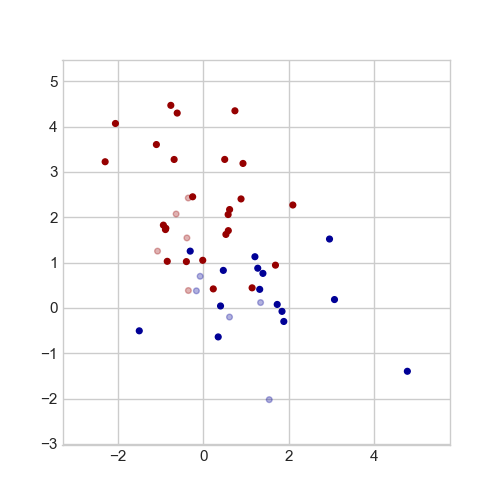

In [36]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
ax.set_xlim(x0_range)
ax.set_ylim(x1_range)
# TRAIN
ax.scatter(x0, x1, s = 17, 
          alpha=1, c=colors )
# TEST
ax.scatter(x0_test, x1_test, s = 17, 
          alpha=0.3, c=colors_test )

ax.figure.canvas.draw()

## Logistic Regression with sklearn

In [37]:
from sklearn.linear_model import LogisticRegression
clf_log = LogisticRegression(solver='lbfgs', multi_class='multinomial').fit(X_train,Y_train)

We can extract the coefficients of the linear regression to plot the decision boundary

In [38]:
# Coefficients of the linear regression's bondary. Bias and slopes
bias = clf_log.intercept_[0]
alpha0, alpha1 = tuple(clf_log.coef_[0])
x_line = x0_range
y_line = tuple(-(bias+alpha0*x)/alpha1 for x in x_line)

<IPython.core.display.Javascript object>


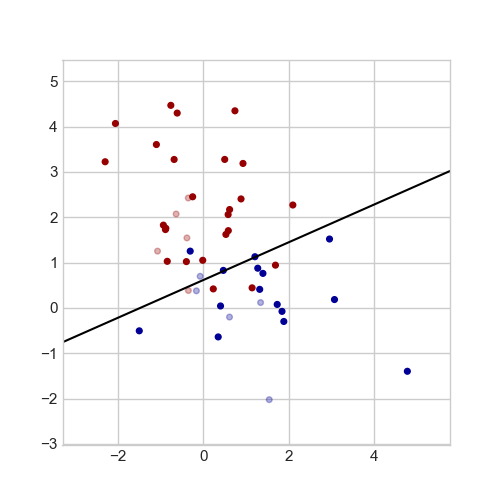

In [39]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
ax.set_xlim(x0_range)
ax.set_ylim(x1_range)
# TRAIN
ax.scatter(x0, x1, s=17, alpha=1, c=colors)
# TEST
ax.scatter(x0_test, x1_test, s=17, alpha=0.3, c=colors_test)
# LINE
ax.plot(x_line, y_line, c='black')
# PLOT ALL
ax.figure.canvas.draw()

## Classification Decision Tree with Sklearn

In [40]:
from sklearn import tree
clf_gini = tree.DecisionTreeClassifier(criterion='gini').fit(X_train, Y_train)
clf_ent = tree.DecisionTreeClassifier(criterion='entropy').fit(X_train, Y_train)

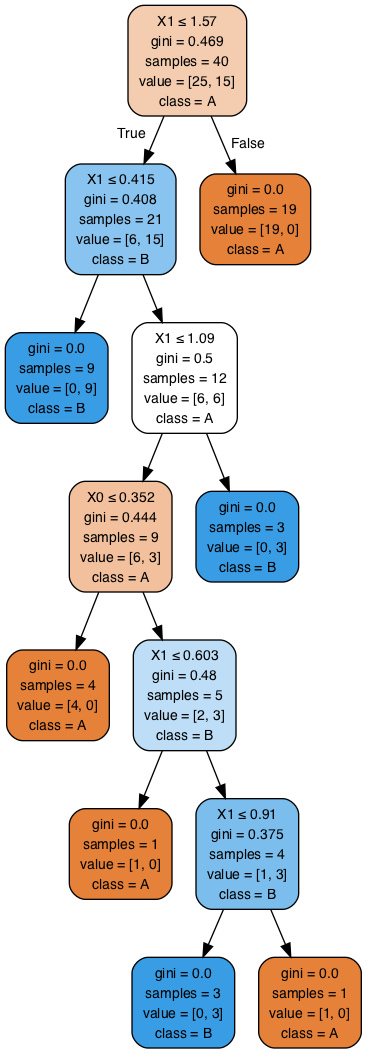

In [41]:
print_tree_sklearn(clf_gini)

<IPython.core.display.Javascript object>


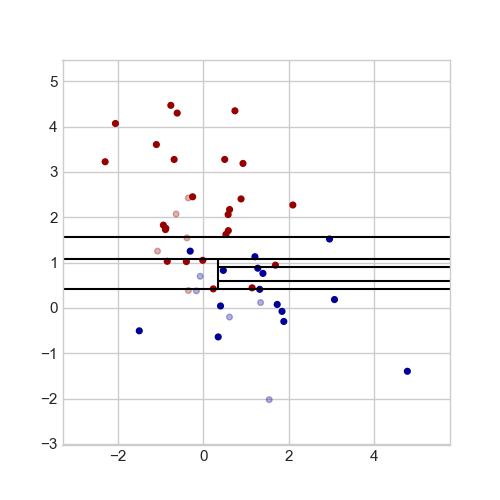

In [42]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
# AXES LIMITS
ax.set_xlim(x0_range)
ax.set_ylim(x1_range)
# TRAIN
ax.scatter(x0, x1, s = 17, alpha=1, c=colors )
# TEST
ax.scatter(x0_test, x1_test, s = 17, alpha=0.3, c=colors_test )
# DECISSION TREE BOUNDARIES
plot_tree_boundaries(ax,clf_gini)

<IPython.core.display.Javascript object>


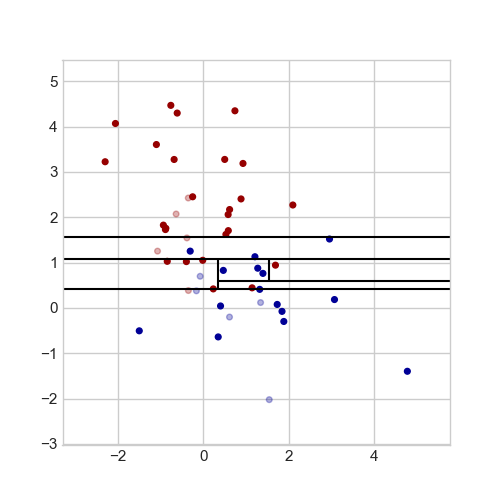

In [43]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
# AXES LIMITS
ax.set_xlim(x0_range)
ax.set_ylim(x1_range)
# TRAIN
ax.scatter(x0, x1, s=17, alpha=1, c=colors)
# TEST
ax.scatter(x0_test, x1_test, s=17, alpha=0.3, c=colors_test)
# DECISSION TREE BOUNDARIES
plot_tree_boundaries(ax, clf_ent)

Different criteria change the decision boundaries.

We can see how the algorithm works exploring how the boundaries are created step by step.

<IPython.core.display.Javascript object>


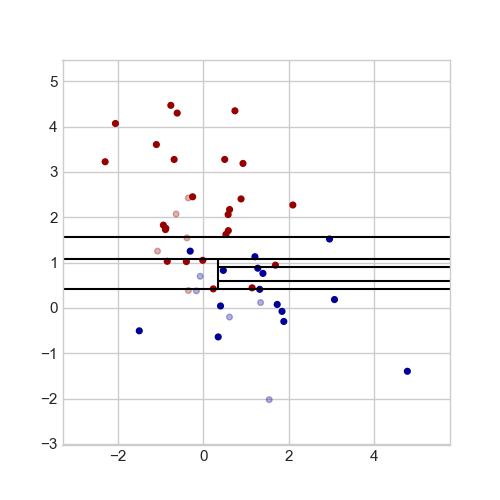

interactive(children=(IntSlider(value=3, description='step', max=6), Output()), _dom_classes=('widget-interact…

In [44]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
# AXES LIMITS
ax.set_xlim(x0_range)
ax.set_ylim(x1_range)
# TRAIN
ax.scatter(x0, x1, s=17, alpha=1, c=colors)
# TEST
ax.scatter(x0_test, x1_test, s=17, alpha=0.3, c=colors_test)
# DECISSION TREE BOUNDARIES
plot_interacting_tree_boundaries(ax, clf_gini)

## Some lessons

**Properties:**
- The decision tree behaves as a nested set of if else conditions.
- Interpretable (at least the first nodes)
    -  We can know why we got a prediction
    -  Contrast with common sense and domain knowledge
- Decision trees will overfit
- But will generalize using next parameters:
    -  min_samples_leaf
    -  min_samples_split 
    -  max_depth 
    -  max_leaf_nodes
- Compared to a plain logistic regression, decision trees are slower (no vectorization), but really fast (we can do hyperparameter optimization)
- We have many hyperparameters (size of data, depth of tree, etc)
- No standarization / normalization (Using original units we will be able to understand the tree better)
- Remember that decision boundaries are always orthogonal to the axis, PCA can be useful
- Feature selection for free (not used if it not important clf.feature_importances_)
- Ordinal categorical variables are treated nicely (They have an intrinsic order, and grouped with neighbours)
- Low stability (Small changes in data, can cause a big change in the model)


## Decision tree from scratch (dict)

In [45]:
def entropy(n_classes):
    """
    Calculate the entropy of a discrete distribution. 

    Parameters
    ----------
    n_classes : np.array, rank=1
        Array with the number of elements in each class.

    Returns
    -------
    ent : float
        Entropy of the distribution.
    """
    # We have to avoid having a left/right part with no elements
    # The number does not matter, since it will be multiplied by prob_right/left = 0.
    if np.sum(n_classes) == 0:
        return 9999999.
    probs = n_classes / np.sum(n_classes)
    # Regularize null probabilities
    probs = probs[probs > 0.]
    # Calculate entropy
    ent = -np.sum(probs * np.log2(probs))
    return ent


def get_best_split(X, Y, class_values=[0, 1], criterion='entropy'):
    """
    Calculate the best split. 

    Parameters
    ----------
    X : np.array, rank=2 (#items,#features)
        Array with the inputs.
    Y : np.array, rank=1 (#items)
        Array with the output class of each input.
    class_values : list of int/float or np.array
        List with the outputs associated with each class.
    criterion : str, default='entropy'
        Criterion to follow to choose the best split.
        'entropy' = Minimize the entropy - p * log2(p)

    Returns
    -------
    best_split : tuple (int, float)
        Best split, the feature index (in X) and its threshold.
        best_split = (feature, threshold)
    """

    best_split = None
    best_criterion = 9999999.
    # Transform class_values to have one row and as many columns as classes
    class_values = np.array(class_values).reshape((1, -1))
    # Have to loop over all the features and all the possible splits in each feature
    for feature, values_feature in enumerate(X.T):
        # Sort the values of that feature
        values_sorted = np.sort(values_feature)
        # Notice that the number of possible splits is one less than the number of points
        for index, value in enumerate(values_sorted[:-1]):
            # LEFT PART, <= value
            '''
            Explanation of the line below
            =============================
            Goal: Count the number of items in each class on the left part.
            1) What is the left part? Values of the feature <= given value
                condition = X[:,feature] <= value
            2) Take the Y values of those elements.
               Note: We reshape it to have only one column, we need that for broadcasting.
                Y[condition].reshape((-1,1)) 
            3) Compare the Y's given above with the value associated to each class
               Each column is the comparison with each class. # colums = # classes 
                condition_class = Y[condition].reshape((-1,1)) == class_values
            4) Sum over all the elements in a row to obtain the number of elements in each class
                np.sum(condition_class,axis=0)
            '''
            n_classes_left = np.sum(
                                    Y[X[:, feature] <= value].reshape((-1, 1)) == class_values,
                                    axis=0)
            # Apply the criterion
            if criterion == 'entropy':
                criterion_left = entropy(n_classes_left)
            # Calculate the probability of the left portion: prob_left = n_points_left/n_points
            prob_left = np.sum(n_classes_left) / Y.size

            # RIGTH PART, > value
            n_classes_right = np.sum(
                                     Y[X[:, feature] > value].reshape((-1, 1)) == class_values,
                                     axis=0)
            if criterion == 'entropy':
                criterion_right = entropy(n_classes_right)
            prob_right = np.sum(n_classes_right) / Y.size

            # Calculate the mean value of the quantity of the criterion
            criterion_split = prob_left * criterion_left + prob_right * criterion_right
            # Keep track of the best split, update it if neccesary
            if criterion_split < best_criterion:
                best_split = (feature, (value + values_sorted[index + 1]) / 2)
                best_criterion = criterion_split
    return best_split


def train_decision_tree(X,Y,class_values=[0, 1],
                        criterion='entropy',
                        min_samples_leaf=1):
    """
    Train decision tree and save the structure in a nested dict.

    Parameters
    ----------
    X : np.array, rank=2 (#items,#features)
        Array with the inputs.
    Y : np.array, rank=1 (#items)
        Array with the output class of each input.
    class_values : list of int/float or np.array
        List with the outputs associated with each class.
    criterion : str, default='entropy'
        Criterion to follow to choose the best split.
        'entropy' = Minimize the entropy - p * log2(p)
    min_samples_leaf : int, default=1

    Returns
    -------
    tree_dict : dict
        Nested dictionary with the structure of the decision tree.
        Each node consists of a dictionary:
           node_dict = {'feature': int, 'threshold': float, 'left': dict, 'right': dict}
        'feature' is the feature index as it appears in X.
        'threshold' is the vlaue of the threshold for that split.
        'left' is the left child. values < threshold
        'right' is the right child. values > threshold
        If a node has no child/children, then 'left' and/or 'right' = None
    """
    # Given the dataset, we evaluate the best split (feature,threshold)
    feature, threshold = get_best_split(
        X, Y, class_values=class_values, criterion=criterion)
    # Separate the dataset into left and right parts.
    X_left = X[X[:, feature] <= threshold]
    Y_left = Y[X[:, feature] <= threshold]
    # If there is more than one class in the region and the number of items is > min_samples_leaf
    # we iterate the splitting.
    if (np.unique(Y_left).size > 1) and (Y_left.size > min_samples_leaf):
        left_node = train_decision_tree(
            X_left,
            Y_left,
            class_values=class_values,
            min_samples_leaf=min_samples_leaf)
    else:
        left_node = None
    X_right = X[X[:, feature] > threshold]
    Y_right = Y[X[:, feature] > threshold]
    if (np.unique(Y_right).size > 1) and (Y_right.size > min_samples_leaf):
        right_node = train_decision_tree(
            X_right,
            Y_right,
            class_values=class_values,
            min_samples_leaf=min_samples_leaf)
    else:
        right_node = None
    return {
        'feature': feature,
        'threshold': threshold,
        'left': left_node,
        'right': right_node
    }

In [46]:
dic_tree = train_decision_tree(X_train,Y_train)
tree_dic_to_nodes(dic_tree)

[Node(feature='X1', threshold=1.5704829305085017, left=1, right=12),
 Node(feature='X1', threshold=0.41496809939421764, left=2, right=3),
 Node(feature=None, threshold=-2.0, left=-1, right=-1),
 Node(feature='X1', threshold=1.0900992629960125, left=4, right=11),
 Node(feature='X0', threshold=0.35202739523164506, left=5, right=6),
 Node(feature=None, threshold=-2.0, left=-1, right=-1),
 Node(feature='X0', threshold=1.545495186616487, left=7, right=10),
 Node(feature='X1', threshold=0.6027503064447972, left=8, right=9),
 Node(feature=None, threshold=-2.0, left=-1, right=-1),
 Node(feature=None, threshold=-2.0, left=-1, right=-1),
 Node(feature=None, threshold=-2.0, left=-1, right=-1),
 Node(feature=None, threshold=-2.0, left=-1, right=-1),
 Node(feature=None, threshold=-2.0, left=-1, right=-1)]

<IPython.core.display.Javascript object>


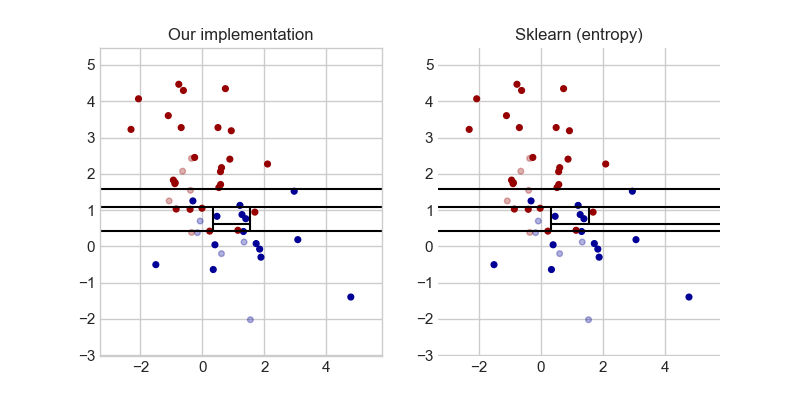

In [47]:
fig = plt.figure(figsize=(8, 4))
# FIRST SUBPLOT
ax=plt.subplot(1, 2, 1)
# AXES LIMITS
ax.set_xlim(x0_range)
ax.set_ylim(x1_range)
ax.set_title('Our implementation')
# TRAIN
ax.scatter(x0, x1, s = 17, alpha=1, c=colors )
# TEST
ax.scatter(x0_test, x1_test, s = 17, alpha=0.3, c=colors_test )
# DECISSION TREE BOUNDARIES
plot_tree_boundaries(ax,dic_tree,is_nodes=False,is_sklearn_clf=False)
# SECOND SUBPLOT
ax2=plt.subplot(122, frameon=False)
# AXES LIMITS
ax2.set_xlim(x0_range)
ax2.set_ylim(x1_range)
ax2.set_title('Sklearn (entropy)')
# TRAIN
ax2.scatter(x0, x1, s = 17, 
          alpha=1, c=colors )
# TEST
ax2.scatter(x0_test, x1_test, s = 17, 
          alpha=0.3, c=colors_test )
# DECISSION TREE BOUNDARIES
plot_tree_boundaries(ax2,clf_ent)

## Exercise: 

Implement the Decission Tree Classifier using the gini index instead of the entropy and compare with the sklearn solution.

This is, create the `gini` index function and introduce it into 
`get_best_split`
and 
`train_decision_tree`


In [ ]:
def gini(n_classes): 
    ### TODO
    return gin

## Exercise: 

Implement a `max_depth` option in our `train_decision_tree` function.

## Exercise: 

Implement a predict function using our decision tree structure.

## Another implementation
https://machinelearningmastery.com/implement-decision-tree-algorithm-scratch-python/

In [177]:
# Split a dataset based on an attribute and an attribute value
def test_split(index, value, dataset):
    left, right = list(), list()
    for row in dataset:
        if row[index] < value:
            left.append(row)
        else:
            right.append(row)
    return left, right

# Calculate the Gini index for a split dataset


def gini_index(groups, classes):
    # count all samples at split point
    n_instances = float(sum([len(group) for group in groups]))
    # sum weighted Gini index for each group
    gini = 0.0
    for group in groups:
        size = float(len(group))
        # avoid divide by zero
        if size == 0:
            continue
        score = 0.0
        # score the group based on the score for each class
        for class_val in classes:
            p = [row[-1] for row in group].count(class_val) / size
            score += p * p
        # weight the group score by its relative size
        gini += (1.0 - score) * (size / n_instances)
    return gini

# Select the best split point for a dataset


def get_split(dataset):
    class_values = list(set(row[-1] for row in dataset))
    b_index, b_value, b_score, b_groups = 999, 999, 999, None
    for index in range(len(dataset[0])-1):
        for row in dataset:
            groups = test_split(index, row[index], dataset)
            gini = gini_index(groups, class_values)
            if gini < b_score:
                b_index, b_value, b_score, b_groups = index, row[index], gini, groups
    return {'index': b_index, 'value': b_value, 'groups': b_groups}

# Create a terminal node value


def to_terminal(group):
    outcomes = [row[-1] for row in group]
    return max(set(outcomes), key=outcomes.count)

# Create child splits for a node or make terminal


def split(node, max_depth, min_size, depth):
    left, right = node['groups']
    del(node['groups'])
    # check for a no split
    if not left or not right:
        node['left'] = node['right'] = to_terminal(left + right)
        return
    # check for max depth
    if depth >= max_depth:
        node['left'], node['right'] = to_terminal(left), to_terminal(right)
        return
    # process left child
    if len(left) <= min_size:
        node['left'] = to_terminal(left)
    else:
        node['left'] = get_split(left)
        split(node['left'], max_depth, min_size, depth+1)
    # process right child
    if len(right) <= min_size:
        node['right'] = to_terminal(right)
    else:
        node['right'] = get_split(right)
        split(node['right'], max_depth, min_size, depth+1)

# Build a decision tree


def build_tree(train, max_depth, min_size):
    root = get_split(train)
    split(root, max_depth, min_size, 1)
    return root

# Print a decision tree


def print_tree(node, depth=0):
    if isinstance(node, dict):
        print('%s[X%d < %.3f]' %
              ((depth*' ', (node['index']+1), node['value'])))
        print_tree(node['left'], depth+1)
        print_tree(node['right'], depth+1)
    else:
        print('%s[%s]' % ((depth*' ', node)))


dataset = np.hstack([X_train, Y_train.reshape((-1, 1))])
tree = build_tree(dataset, 15, 5)
print_tree(tree)

[X2 < 1.253]
 [X1 < 1.145]
  [X1 < -1.163]
   [1.0]
   [X1 < -1.163]
    [1.0]
    [1.0]
  [1.0]
 [X1 < -1.100]
  [0.0]
  [X1 < 0.331]
   [X1 < -0.936]
    [0.0]
    [0.0]
   [0.0]


In [178]:
tree

{'index': 1,
 'value': 1.2530523446866586,
 'left': {'index': 0,
  'value': 1.1447237098396141,
  'left': {'index': 0,
   'value': -1.1626324029933965,
   'left': 1.0,
   'right': {'index': 0,
    'value': -1.1626324029933965,
    'left': 1.0,
    'right': 1.0}},
  'right': 1.0},
 'right': {'index': 0,
  'value': -1.0998912673140309,
  'left': 0.0,
  'right': {'index': 0,
   'value': 0.3306753193956881,
   'left': {'index': 0,
    'value': -0.9357694342590688,
    'left': 0.0,
    'right': 0.0},
   'right': 0.0}}}

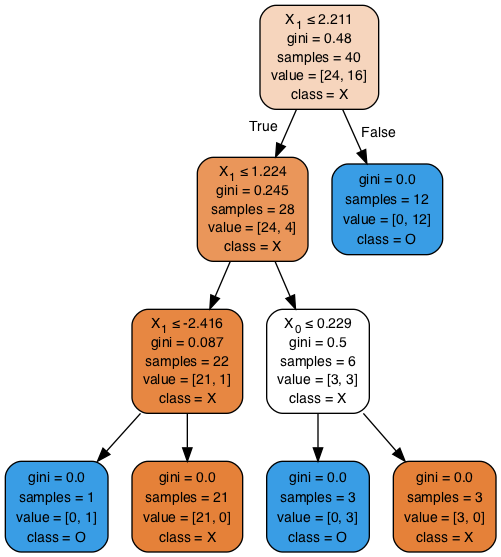

In [230]:
print_cart(clf)